# Finding a planet

data for this lecture should be downloaded here:<br>
https://www.dropbox.com/s/ycoikiu6jnxcadt/planet_x.tar.gz?dl=0 <br>
Let's start using the magic function we learned last time "%pylab inline"
<br> then we can import the packeages we will use today: sep, astropy  
<br> from astropy we will import: fits and wcs

In [1]:
%pylab inline
from astropy.io import fits
from astropy import wcs as wcs
import sep
import glob
from astropy.wcs import WCS

Populating the interactive namespace from numpy and matplotlib


We will use the command glob to make a list of all the images in our directory. Then let's plot the first image and the following 5 stars:

<br> STAR1_RA = 268.020833333
<br> STAR1_DEC = 37.5114388889

<br> STAR2_RA = 268.02924375
<br> STAR2_DEC = 37.5461769444

<br> STAR3_RA = 268.018954167
<br> STAR3_DEC = 37.5375666667

<br> STAR4_RA = 268.039104167
<br> STAR4_DEC = 37.5067611111

<br> STD_RA = 268.059616667 
<br> STD_DEC = 37.5372694444

In order to do that we need to use the package <font color='blue'> wcs </font> and convert all coordinates in pixels:

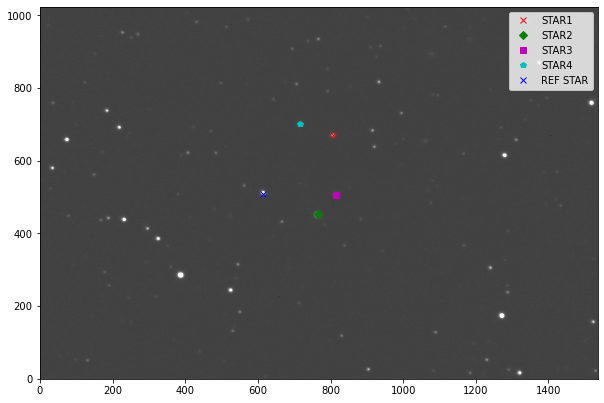

In [2]:
STAR1_RA = 268.020833333
STAR1_DEC = 37.5114388889

STAR2_RA = 268.02924375
STAR2_DEC = 37.5461769444

STAR3_RA = 268.018954167
STAR3_DEC = 37.5375666667

STAR4_RA = 268.039104167
STAR4_DEC = 37.5067611111

STD_RA = 268.059616667 
STD_DEC = 37.5372694444

imglist = glob.glob('*fits')
hdu= fits.open(imglist[0])
header = hdu[0].header
X = hdu[0].data

plt.figure(figsize=(10,12))
imgshow = plt.imshow(X, origin='lower', cmap='gray', vmin=50, vmax=1800)

w = WCS(header)
#transform SN coordinate in pixels:
px1, py1 = w.wcs_world2pix(STAR1_RA,STAR1_DEC, 1)
px2, py2 = w.wcs_world2pix(STAR2_RA,STAR2_DEC, 1)
px3, py3 = w.wcs_world2pix(STAR3_RA,STAR3_DEC, 1)
px4, py4 = w.wcs_world2pix(STAR4_RA,STAR4_DEC, 1)

std_px, std_py = w.wcs_world2pix(STD_RA,STD_DEC, 1)

plt.plot(px1, py1,'xr', label = 'STAR1')
plt.plot(px2, py2,'Dg', label = 'STAR2')
plt.plot(px3, py3,'sm', label = 'STAR3')
plt.plot(px4, py4,'pc', label = 'STAR4')
plt.plot(std_px, std_py,'xb',label = 'REF STAR')
plt.legend()

<font color='blue'> let's measure flux for one of them (1,2,3,4) + the REF STAR </font>
<br> To do that we need to extract all objects from the image and identify the coser detections to those stars using the package sep. and then using again the package sep we can measure the flux.
<br> In reality you could just try to measure the flux on these pixels we got, but se extraction may actually get a better position of the star.
<br> Remember that to find all the star in the image we should first subtract the background amd run these 3 commands:
<br> <font color='blue'> X = hdu[0].data
<br> X  = X.byteswap().newbyteorder()
<br> bkg = sep.Background(X) #compute the background of the image
<br> data_sub = X - bkg #subtract the background to the image </font>


In [3]:
hdu= fits.open(imglist[10])
header = hdu[0].header
X = hdu[0].data
X = X.byteswap().newbyteorder()
# compute the background of the image
bkg = sep.Background(X)
# subtract the background to the image
data_sub = X - bkg
# extract all the object in the image 
objects = sep.extract(data_sub, thresh=3.0, err=bkg.globalrms, mask=None, \
                    minarea=10, clean=True, filter_type = 'matched',\
                    clean_param=1.0, segmentation_map=False)


star = False
std  = False
for i,j in enumerate(objects['x']):
    if (objects['x'][i] - px1)**2+(objects['y'][i] - py1)**2 <25:
            star=i
    if (objects['x'][i]-std_px)**2+(objects['y'][i]- std_py)**2 < 25:
            std=i
    if std is not False and star is not False:
        # measure the flux
        fluxstar, fluxstarerr, flagstar = sep.sum_circle(data_sub, [objects['x'][star]], [objects['y'][star]],
                                     5.0, err=bkg.globalrms, gain=1.0)
        fluxstd, fluxstderr, flagstd = sep.sum_circle(data_sub, [objects['x'][std]], [objects['y'][std]],
                                     5.0, err=bkg.globalrms, gain=1.0)
        print('Found a nearby star to teh star and the standard')
        print(fluxstar, objects['x'][star],objects['y'][star],px1,px2)
        print(fluxstd, objects['x'][std],objects['y'][std],std_px,std_py)
        break

Found a nearby star to teh star and the standard
[54364.23696045] 809.3177379541713 669.290026910277 807.0200994297325 764.9094445313767
[144898.52863281] 617.2530961312644 510.983141881607 613.7780669815903 508.41522598559123


Now we would like to repeat thi for all the images storing the the flux for each image in a vector. At the same time we also need to store from the header the time when the image was observed (JD). 
<br> <font color='blue'> Let's first define empty list and fill the JD list during a loop on all the images. </font>

In [4]:
jd_vec = []
for img in imglist:
    hdu= fits.open(img)
    header = hdu[0].header
    X = hdu[0].data
    X = X.byteswap().newbyteorder()
    bkg = sep.Background(X)
    data_sub = X - bkg
    jd_vec.append(header['jd'])
print(jd_vec)

[2455814.6614930555, 2455814.7651388887, 2455814.736701389, 2455814.723900463, 2455814.777627315, 2455814.673622685, 2455814.769201389, 2455814.6655324074, 2455814.7322569443, 2455814.781979167, 2455814.6777546294, 2455814.8043981483, 2455814.699363426, 2455814.6902199076, 2455814.795, 2455814.7075462965, 2455814.746226852, 2455814.758912037, 2455814.7544791666, 2455814.7483333335, 2455814.756724537, 2455814.7441666666, 2455814.734560185, 2455814.7754166666, 2455814.6716087963, 2455814.725960648, 2455814.6757523147, 2455814.7798263887, 2455814.7217708332, 2455814.6635185187, 2455814.7672569444, 2455814.709571759, 2455814.6880324073, 2455814.792881944, 2455814.802210648, 2455814.697337963, 2455814.784224537, 2455814.6797685185, 2455814.739895833, 2455814.7524305554, 2455814.8063541665, 2455814.701377315, 2455814.801238426, 2455814.6963541666, 2455814.7885648147, 2455814.6838194444, 2455814.7134722224, 2455814.7054861113, 2455814.6923032408, 2455814.7969444445, 2455814.717592593, 2455814

<br> <font color='blue'> Let's now also define an empty list for the star flux and error. We will add one element to the list </font>

In [5]:
jd_vec = []
flux_vec =[]
fluxerr_vec =[]
for img in imglist:
    hdu= fits.open(img)
    header = hdu[0].header
    X = hdu[0].data
    X = X.byteswap().newbyteorder()
    bkg = sep.Background(X)
    data_sub = X - bkg
    # Now we can exstract all the objects from the image using the sep commmand 
    # sep.extract and then we can plot all the star detected on our image.  
    # thresh=3.0 define how many star we want to find larger numbers means 
    # we find less objects. This is similar to a dictionary with each column 
    # that can be identify by a name. 
    objects = sep.extract(data_sub, thresh=3.0, err=bkg.globalrms, mask=None, \
                          minarea=10, clean=True, filter_type = 'matched',\
                          clean_param=1.0, segmentation_map=False) 
    w = WCS(header)
    #transform STAR coordinate in pixels:
    px, py = w.wcs_world2pix(STAR2_RA,STAR2_DEC, 1)
    
    for i,j in enumerate(objects['x']):
        if (objects['x'][i]-px)**2+(objects['y'][i]-py)**2 <25:
            #print("one star close to the coordinates")
            fluxstar, fluxstarerr, flagstar = sep.sum_circle(data_sub, [objects['x'][i]], [objects['y'][i]],
                                     5.0, err=bkg.globalrms, gain=1.0)
            flux_vec.append(fluxstar)
            fluxerr_vec.append(fluxstarerr)
            jd_vec.append(header['jd'])
            # once we find the closest star we can stop the enumerate with "break"
            break



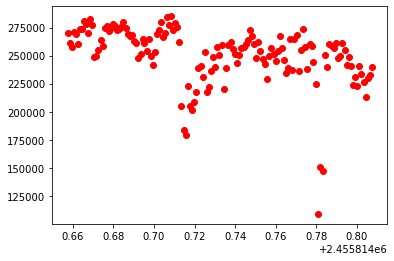

In [6]:
plt.plot(jd_vec,flux_vec,'or')

this does not look great, this is because the night of observations may not be all good and we need to compare our fluxes with those os a reference star to remove the contamination due to the atmosphere. let's do the same also for a reference star

In [7]:
jd_vec = []
flux_vec =[]
fluxerr_vec =[]
flux_std_vec=[]
for img in imglist:
    hdu= fits.open(img)
    header = hdu[0].header
    X = hdu[0].data
    X = X.byteswap().newbyteorder()
    bkg = sep.Background(X)
    data_sub = X - bkg
    # Now we can exstract all the objects from the image using the sep commmand 
    # sep.extract and then we can plot all the star detected on our image.  
    # thresh=3.0 define how many star we want to find larger numbers means 
    # we find less objects. This is similar to a dictionary with each column 
    # that can be identify by a name. 
    objects = sep.extract(data_sub, thresh=3.0, err=bkg.globalrms, mask=None, \
                          minarea=10, clean=True, filter_type = 'matched',\
                          clean_param=1.0, segmentation_map=False) 
    w = WCS(header)
    #transform STAR and REF coordinates in pixels:
    px, py = w.wcs_world2pix(STAR2_RA, STAR2_DEC, 1)
    std_px, std_py = w.wcs_world2pix(STD_RA,STD_DEC, 1)
    
    star = False
    std  = False
    for i,j in enumerate(objects['x']):
        if (objects['x'][i] - px)**2+(objects['y'][i] - py)**2 <25:
                star=i
        if (objects['x'][i]-std_px)**2+(objects['y'][i]- std_py)**2 < 25:
                std=i
        if std is not False and star is not False:
            # measure the flux
            fluxstar, fluxstarerr, flagstar = sep.sum_circle(data_sub, [objects['x'][star]], [objects['y'][star]],
                                         5.0, err=bkg.globalrms, gain=1.0)
            fluxstd, fluxstderr, flagstd = sep.sum_circle(data_sub, [objects['x'][std]], [objects['y'][std]],
                                         5.0, err=bkg.globalrms, gain=1.0)
    
            flux_vec.append(fluxstar)
            fluxerr_vec.append(fluxstarerr)
            flux_std_vec.append(fluxstd)
            jd_vec.append(header['jd'])
            # once we find the closest star we can stop the enumerate with "break"
            break

In [8]:
#let's convert the lists in array
flux_vec = np.array(flux_vec)
flux_std_vec = np.array(flux_std_vec)

Text(0, 0.5, 'Flux Star 2')

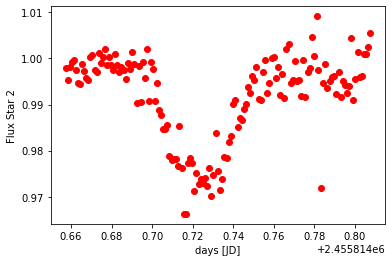

In [9]:
plt.plot(jd_vec, flux_vec/flux_std_vec/1.88,'or')
plt.xlabel('days [JD]')
plt.ylabel('Flux Star 2')

We found a planets orbiting STAR 2, the flux decreae of % 3%